In [1]:
import torch
import torch.nn as nn
from e3nn import o3

# Invarian GNN block

Let's set up feature dimension and filter dimension

In [2]:
feature_dimension = 8
filter_dimension = 16

Embedding (here, lets say we have 5 different elements)

In [3]:
n_el = 5
embeding_block = nn.Embedding(n_el,feature_dimension)
element_label = torch.tensor([0])
embeding_vector = embeding_block(element_label)

In [4]:
print(embeding_vector)

tensor([[ 0.1977, -1.5485,  0.8426, -0.5883,  0.9012,  0.0845,  1.1442,  0.9870]],
       grad_fn=<EmbeddingBackward0>)


Linear blocks for atom-wise interaction (feature to feature) and feature 

In [5]:
feature_to_filter = nn.Linear(feature_dimension,filter_dimension,bias=False)
filter_vector = feature_to_filter(embeding_vector)
print(filter_vector)

tensor([[ 0.4558,  0.2448, -0.5976,  0.4381, -0.1633,  0.3830, -1.0008,  0.0567,
          1.1555,  0.2914, -0.1751,  0.0683,  0.7724,  0.0715, -0.2891, -0.3082]],
       grad_fn=<MmBackward0>)


Activations are as `torch.nn.functional`

In [6]:
activated_filter = nn.functional.silu(filter_vector)
print(filter_vector)

tensor([[ 0.4558,  0.2448, -0.5976,  0.4381, -0.1633,  0.3830, -1.0008,  0.0567,
          1.1555,  0.2914, -0.1751,  0.0683,  0.7724,  0.0715, -0.2891, -0.3082]],
       grad_fn=<MmBackward0>)


Hint for edge to filter
Here I will take just distances from points in the cutoff. Here i will assume that we have two atoms in the distance 3.0 and 2.3 from the center atom

In [7]:
offset = torch.linspace(0.0,6,10)
d_ij = torch.tensor([3.0,2.3])
j = (d_ij.unsqueeze(-1)-offset)

In [8]:
tmp = nn.Linear(10,filter_dimension)
tmp(j)

tensor([[-0.4161,  0.3511, -0.5345, -0.4316,  1.1258,  0.2824,  1.4438,  0.6165,
         -1.5535,  1.8052, -0.7393,  1.0474, -0.7737,  0.8231, -0.1093,  2.3561],
        [ 0.1373, -0.2141, -0.4644,  0.6984,  0.8378,  0.3657,  1.6618,  0.4207,
         -1.2342,  2.4215, -0.9099,  0.9863, -0.7009,  0.7518,  0.8876,  2.3294]],
       grad_fn=<AddmmBackward0>)

Class for the distance RBF

In [9]:
class RBFdistance(nn.Module):
    def __init__(self,cutoff,n_distances):
        super().__init__()
        offset = torch.linspace(0.0,cutoff,n_distances)

    def forward(self,d_ij):
        return d_ij.unsqueeze(-1)-offset
        

# Basics of e3n

`o3` group means no translation.

 Here I will show some e3nn stuff which won't be really needed, just to see the tensor product behaviour. This was also very heavily influanced by [MACE tutorila](https://colab.research.google.com/drive/1AlfjQETV_jZ0JQnV5M3FGwAM2SGCl2aU#scrollTo=E-lt2fyV_03E) 

## Basic operation

Creation of the irreps is easily done like this

In [10]:
from e3nn import o3
irreps1 = o3.Irreps("3x2o+5x3e")
print(irreps1.dim)
# you can create a random irreps:
my_ir = irreps1.randn(-1,1)
my_ir = torch.tensor([0.3 for _ in range(irreps1.dim)])
# or you can just create a torch.tensor of the 

50


## Spherical harmonics

First spherical harmonics needed for the filter

In [11]:
# a function for Ylms where we evaluate for l=0,1,2.
spherical_harmonics = o3.SphericalHarmonics([0,1,2], True)

# evaulate spherical harmonics on a vector
vector = torch.tensor([1.0, 0.2, 0.75])
print(spherical_harmonics(vector)) # size if because scalar (1) + vector (3) + tensor (5)

tensor([ 0.2821,  0.3860,  0.0772,  0.2895,  0.5113,  0.1364, -0.2918,  0.1023,
        -0.1491])


# Tensor product
Here Is the full tensor product, which at the end won't be used today

FullTensorProduct(2x0e+3x1o x 5x0e+7x1e -> 21x0o+10x0e+36x1o+14x1e+21x2o | 102 paths | 0 weights)


/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


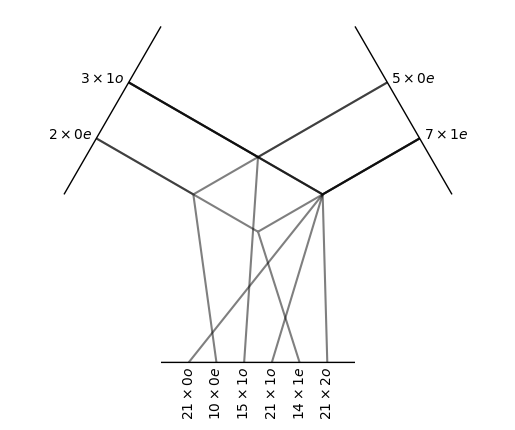

In [12]:
tp = o3.FullTensorProduct(
    irreps_in1='2x0e + 3x1o',
    irreps_in2='5x0e + 7x1e'
)
print(tp)
tp.visualize();

This is how to set up tensor product we will need today

FullyConnectedTensorProduct(5x0e+5x1e x 6x0e+4x1e -> 15x0e+3x1e | 960 paths | 960 weights)


/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


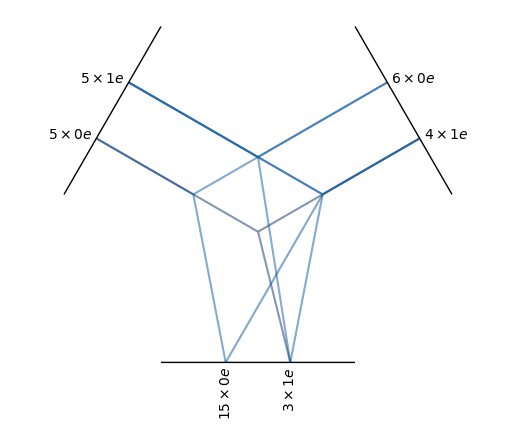

In [13]:
tp = o3.FullyConnectedTensorProduct(
    irreps_in1='5x0e + 5x1e',
    irreps_in2='6x0e + 4x1e',
    irreps_out='15x0e + 3x1e'
)
print(tp)
tp.visualize();

FullyConnectedTensorProduct(1x1o x 3x0e+1x1o+5x2e -> 3x0e | 3 paths | 3 weights)


/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>, <Axes: >)

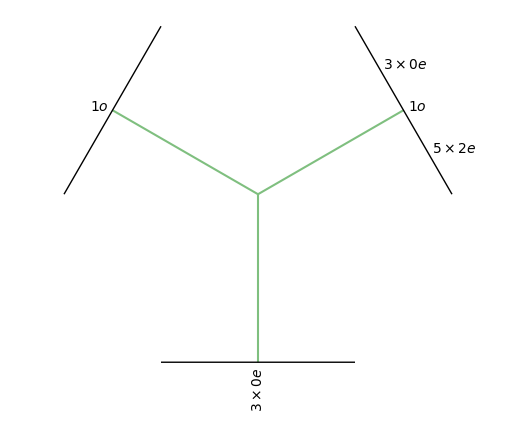

In [14]:
# set up a tensor product.
# This does the product of two l=0,1,2 arrays, and maps the result to three l=0 values.
tensor_product = o3.FullyConnectedTensorProduct(
    irreps_in1=o3.Irreps("1x1o"),
    irreps_in2=o3.Irreps("3x0e + 1x1o + 5x2e"),
    irreps_out=o3.Irreps("3x0e"),
    internal_weights=False
)
print(tensor_product)
tensor_product.visualize()

In [15]:
irresp1 = o3.Irreps("1x1o")
irresp2 = o3.Irreps("3x0e + 1x1o + 5x2e")
# my_irresp1 = irresp1.randn(1,-1)
my_irresp1 = torch.tensor([-1.2,0.2,0.3]).unsqueeze(0)
my_irresp2 = irresp2.randn(1,-1)

In [16]:
print(my_irresp1.shape)
print(my_irresp2.shape)

torch.Size([1, 3])
torch.Size([1, 31])


For convolution you will need to find out how many weights you need. This is different from our invariant case, where this was set up by you, this is dependent on a number of channels and fancy $\ell$ of irreps. Find it like this: 

In [17]:
print(f"{tensor_product} needs {tensor_product.weight_numel} weights")

FullyConnectedTensorProduct(1x1o x 3x0e+1x1o+5x2e -> 3x0e | 3 paths | 3 weights) needs 3 weights


In [18]:
print(torch.arange(1,tensor_product.weight_numel,1).shape)

torch.Size([2])


In [19]:
# product the arrays
product = tensor_product(
    my_irresp1.unsqueeze(0),
    my_irresp2.unsqueeze(0),
    weight=torch.rand(tensor_product.weight_numel) # the product has weights which can be trained - here I will just provide them as random, you have to provide filter values
)
print('invariant outputs:', product)

invariant outputs: tensor([[[-0.0474, -0.0034, -0.0568]]])


Rotate 1 vector and lets see if the scalar values will change

In [20]:
R = o3.rand_matrix()
torch.linalg.norm(torch.matmul(irresp1.D_from_matrix(R),my_irresp1.T).T)

tensor(1.2530)

In [21]:
torch.linalg.norm(my_irresp1)

tensor(1.2530)

In [22]:
rot_irreps1 = torch.matmul(irresp1.D_from_matrix(R),my_irresp1.T).T

In [23]:
# product the arrays
product = tensor_product(
    my_irresp1.unsqueeze(0),
    my_irresp2.unsqueeze(0),
    weight=torch.rand(tensor_product.weight_numel) # the product has weights which can be trained - here I will just provide them as random, you have to provide filter values
)
print('different invariant outputs:', product)

different invariant outputs: tensor([[[-0.0133, -0.0947, -0.0788]]])


### Bilinear
- For nerds, this show bilinearity of the tensor product, we can discuss it but it is not needed
$$
(\alpha x_1 + x_2) \otimes y = \alpha x_1 \otimes y + x_2 \otimes y 
\quad \text{and} \quad 
x \otimes (\alpha y_1 + y_2) = \alpha x \otimes y_1 + x \otimes y_2
$$ 

In [24]:
import torch
from e3nn.o3 import Irreps, TensorProduct


irreps_in1 = Irreps("1x0e + 1x1e")
irreps_in2 = Irreps("1x0e + 1x1e")
irreps_out = Irreps("1x0e + 1x1e")

tp = o3.FullTensorProduct(irreps_in1, irreps_in2)

a1 = irreps_in1.randn(1,-1)
a2 = irreps_in1.randn(1,-1)
b1 = irreps_in2.randn(1,-1)
b2 = irreps_in2.randn(1,-1)

lhs1 = tp(a1 + a2, b1)
rhs1 = tp(a1, b1) + tp(a2, b1)

lhs2 = tp(a1, b1 + b2)
rhs2 = tp(a1, b1) + tp(a1, b2)

print("Check TP(a1 + a2, b1) == TP(a1, b1) + TP(a2, b1):", torch.allclose(lhs1, rhs1))
print("Check TP(a1, b1 + b2) == TP(a1, b1) + TP(a1, b2):", torch.allclose(lhs2, rhs2))


Check TP(a1 + a2, b1) == TP(a1, b1) + TP(a2, b1): True
Check TP(a1, b1 + b2) == TP(a1, b1) + TP(a1, b2): True


/home/mvondrak/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Different D matrices for pseudo vector and vector

irresp1 = o3.Irreps("1x1o")

In [25]:
inversion_matrix = -torch.eye(3)


D_pseudovector = o3.Irreps("1e").D_from_matrix(inversion_matrix)  
D_vector = o3.Irreps("1o").D_from_matrix(inversion_matrix)

In [26]:
print("No change after the inversion\n",D_pseudovector)
print("Change after the inversion\n",D_vector)

No change after the inversion
 tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
Change after the inversion
 tensor([[-1., -0., -0.],
        [-0., -1., -0.],
        [-0., -0., -1.]])
